In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from astropy.io import fits
from alpaca import Telescope, Camera, FilterWheel
from ciboulette.base import ciboulettepy as Cbl
from ciboulette.utils import exposurepy as Exp
import os

In [2]:
# Initialisation Ciboulette
cbl = Cbl.Ciboulette()
cbl.object_name = 'SECTOR1'

# Changement de focale
cbl.focale = 85.0

# Initialisation Exposure
exp = Exp.Exposure()
exp.setexptime(2)

# Initialisation Telescope
# Changement de device pour le telescope simulator
telescope = Telescope(cbl.server, 1)
telescope.sitelatitude(cbl.site_lat)
telescope.sitelongitude(cbl.site_long)
telescope.unpark()
telescope.tracking(True)

# Initialisation FilterWheel
# Changement de device pour le filterwheel remise en l'état
filterwheel = FilterWheel(cbl.server, 2)
filterwheel.position(1)

# Initialisation CCD
# Changement de device pour le ccd remise en l'état
ccd = Camera(cbl.server, 2)

In [3]:
cbl.ciboulettetable()

DRV_NAME,SERVER,DEVICE,FOCAL,SITE_LAT,SITE_LONG,SITE_ELEV,INSTRUME,NAXIS1,NAXIS2,BINXY,PIXELXY,FILTER,NAME,OBSERVER,DATASET,ARCHIVES,RA,DEC,OBECT
str16,str18,int64,float64,float64,float64,int64,str10,int64,int64,int64,float64,str1,str12,str4,str7,str16,float64,float64,str7
FITS astropy 4.2,192.168.1.18:11111,0,85.0,49.5961,-0.3531,100,Atik 383L+,3326,2504,1,5.4,L,CIBOULETTE-A,CAM1,dataset,dataset/archives,0.0,90.0,SECTOR1


In [4]:
inc_DEC_deg = -7 # Incrément de déplacement de la monture en DEC
inc_RA_deg = 0.0000 # Incrément de déplacement de la monture en RA
#frame = [1,2,3,4,5] 
frame = [1]
index = 0

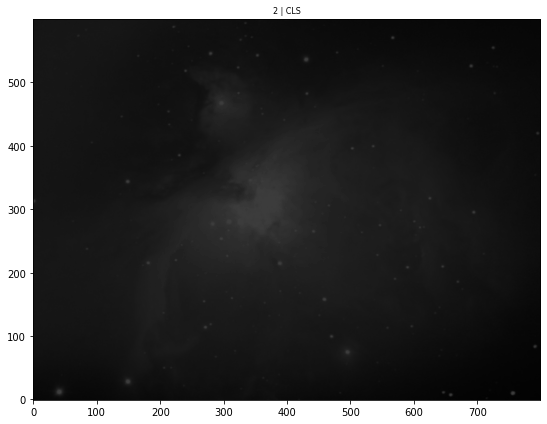

In [7]:
for frameid in frame :
    
    cbl.startexposurealpaca(exp,ccd,telescope,filterwheel)   
    
    if frameid < frame[len(frame)-1] :
        # DEC move
        RA = telescope.rightascension()
        DEC = float(telescope.declination()) + inc_DEC_deg
        telescope.slewtocoordinates(RA,DEC)
        time.sleep(5)
    
    fits_file = cbl.dataset+'/'+cbl.observer_name+'_'+cbl.object_name+'_'+str(exp.number)+'.fits'
    hdu = fits.open(fits_file)[0]
    header = hdu.header
    
    # Affichage
    fig = plt.figure(figsize=(15,7))
    title = str(exp.getnumber())+' | '+ cbl.filter_name
    ax = fig.add_subplot(111)
    fig.add_axes(ax) 
    ax.grid(b = False)
    plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = 16, vmax = 2000)
    ax.set_title(title, fontsize = 8)
    plt.show()
    
    exp.incnumber() 

In [8]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  800                                                  
NAXIS2  =                  600                                                  
PIXSIZE1=                  5.6 / [um] Pixel Size X, binned                      
PIXSIZE2=                  5.6 / [um] Pixel Size Y, binned                      
XBINNING=                    1 / Binning factor X                               
YBINNING=                    1 / Binning factor Y                               
EXPTIME =                    2 / [s] Total Exposure Time                        
OBJECT  = 'SECTOR1 '           / Observed object name                           
OBSERVER= 'CAM1    '           / Observed name                                  
TELESCOP= 'CIBOULETTE-A'    